# Model Evaluation

## Table of Contents
1. Import Libraries
2. Preprocessing
3. Dummy Classifier
4. Logistic Regression
5. Random Forest Classifier
6. Light Gradient Boosting Machine

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
import pickle
import optuna

Using TensorFlow backend.


In [2]:
df = pd.read_csv('nys_cleaned.csv')

In [3]:
pd.set_option('display.max_columns', 110)

### Preprocessing

In [22]:
X = df.drop(columns=['HICOV'])
y = df['HICOV']

continuous_columns = ['AGEP','INTP_cat','OIP_cat','RETP_cat','SEMP_cat','SSIP_cat','JWAP_mins','JWDP_mins','TOTAL_commute','JWMNP','PAP','SSP','WAGP','WKHP','OCCP','PERNP','PINCP',
                     'FINCP','HINCP','MAR_YEARS','NP']
categorical_columns = [x for x in X.columns if x not in continuous_columns]

In [23]:
scaler = StandardScaler()
_X_cont = scaler.fit_transform(X[continuous_columns])
_X_cont_df = pd.DataFrame(data = _X_cont,
                         columns = continuous_columns)


In [25]:
_X_cont_df

,AGEP,INTP_cat,OIP_cat,RETP_cat,SEMP_cat,SSIP_cat,JWAP_mins,JWDP_mins,TOTAL_commute,JWMNP,PAP,SSP,WAGP,WKHP,OCCP,PERNP,PINCP,FINCP,HINCP,MAR_YEARS,NP
0,-1.239857,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,-0.955794,-0.936232,-0.740011,1.123548,-0.090197,-0.486672,-0.448546,1.230394,0.772516,-0.457984,-0.564065,-0.730566,-0.873149,-0.959950,-1.078661
1,-1.502367,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,3.677445,3.879619,-0.196193,-1.187609,-0.090197,-0.486672,-0.510080,-1.068971,0.417765,-0.516662,-0.618578,-0.730566,-0.873149,-0.959950,-1.078661
2,-1.659874,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,-0.955794,-0.936232,-0.740011,1.123548,-0.090197,-0.486672,-0.524730,-1.164778,0.634163,-0.530633,-0.631557,-0.730566,-0.873149,-0.959950,-1.078661
3,1.857764,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,-0.955794,-0.936232,-0.740011,1.123548,-0.090197,1.372175,-0.524730,-1.164778,-1.039910,-0.530633,-0.453740,-0.730566,-0.873149,2.571079,-1.078661
4,-1.607372,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,2.019233,2.171870,-0.558738,-1.152767,-0.090197,-0.486672,-0.511984,-0.973165,-0.074276,-0.518478,-0.620265,-0.730566,-0.873149,-0.959950,-1.078661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159294,-0.714837,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,0.751189,0.686129,1.072714,-0.688213,-0.090197,-0.486672,0.793854,0.751359,-0.678063,0.726753,0.536584,1.035684,0.883742,-0.596462,0.049430
159295,-0.609832,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,0.734932,0.686129,0.891442,-0.746283,-0.090197,-0.486672,1.379891,0.751359,-0.678063,1.285591,1.055758,1.035684,0.883742,-0.596462,0.049430
159296,-1.187355,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,0.344765,0.378734,-0.196193,-1.094698,-0.090197,-0.486672,0.090609,0.990876,-0.258037,0.056147,-0.086425,-0.216748,-0.362053,-0.959950,0.049430
159297,0.335204,-0.125537,-0.134285,-0.245213,-0.111282,-0.169387,0.621133,0.549509,1.072714,-0.688213,-0.090197,-0.486672,-0.202410,0.990876,2.202875,-0.223272,-0.346012,-0.216748,-0.362053,0.494003,0.049430


In [64]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(_X_cont_df)

In [65]:
pca.explained_variance_ratio_

array([0.2741042 , 0.16265443, 0.07856501, 0.05727224, 0.04885368,
       0.04716321, 0.04687397, 0.0453363 , 0.04490779, 0.04085854])

In [66]:
pca.explained_variance_

array([5.75622425, 3.41576445, 1.64987559, 1.20272466, 1.02593367,
       0.9904336 , 0.98435962, 0.95206836, 0.94306941, 0.8580347 ])

In [69]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2',
                                                                 'principal component 3','principal component 4',
                                                                 'principal component 5','principal component 6',
                                                                 'principal component 7','principal component 8',
                                                                 'principal component 9','principal component 10'])

In [70]:
principalDf

,principal component 1,principal component 2,principal component 3,principal component 4,principal component 5,principal component 6,principal component 7,principal component 8,principal component 9,principal component 10
0,-0.956383,-1.446544,1.072497,1.134731,0.668598,0.315560,-0.762413,-0.949790,-0.804960,0.168332
1,2.090888,-3.422174,-2.025617,0.007998,0.995168,-0.123413,0.093184,1.055648,-0.642120,0.220787
2,-1.767048,-1.383769,1.547998,0.948910,0.736329,0.315516,-0.717274,-0.767972,-0.919358,0.230657
3,-3.678539,1.406347,-1.725443,0.478503,-0.785052,-0.266837,-0.143037,-0.296033,0.625750,-1.049076
4,0.890735,-2.723788,-0.833540,0.415142,0.857269,0.048212,-0.182153,0.467308,-0.760117,0.199726
...,...,...,...,...,...,...,...,...,...,...
159294,2.500258,0.313038,0.336951,0.088787,-0.491002,0.236370,0.142754,0.119030,-0.186880,0.031360
159295,2.923649,0.876520,0.342789,0.505880,-0.601064,0.348176,0.163682,-0.050046,-0.239157,0.070560
159296,1.253989,-1.330241,0.412228,0.382102,0.179009,0.199756,-0.239194,-0.197772,-0.454996,0.151860
159297,1.192965,-1.412247,-1.293358,-0.553787,0.067891,-0.283064,0.056155,-0.006118,0.384457,-0.284121


In [71]:
eig_values = pca.explained_variance_
eig_vectors = pca.components_
print(eig_values)
print(eig_vectors)

[5.75622425 3.41576445 1.64987559 1.20272466 1.02593367 0.9904336
 0.98435962 0.95206836 0.94306941 0.8580347 ]
[[-1.94203268e-01  2.52037756e-02 -3.88197797e-02 -9.39057282e-02
   7.31675785e-02 -7.52511062e-02  3.21371859e-01  3.13791303e-01
   2.60538517e-01 -3.18564991e-01 -2.67284122e-02 -2.10674842e-01
   3.00432361e-01  3.37544794e-01  1.56482703e-01  3.06382073e-01
   2.51273556e-01  2.03842323e-01  2.34078444e-01 -1.75433239e-01
   1.06248378e-01]
 [ 2.81548185e-01  2.15706020e-01  5.31407662e-02  1.83264464e-01
   1.35211387e-01  9.99663757e-03 -1.76780961e-01 -1.78701513e-01
  -8.25750743e-02  1.76661485e-01 -1.98652508e-02  2.36748863e-01
   2.69505400e-01 -9.19326370e-02 -2.11483484e-01  2.93759429e-01
   3.93375418e-01  3.22356011e-01  3.43150467e-01  2.64983344e-01
  -5.49608249e-02]
 [-4.08880776e-01  1.39898328e-02 -2.22012718e-02 -1.97429037e-01
   3.93673305e-02  1.38913608e-01 -3.09979477e-01 -3.09233269e-01
  -1.87242275e-01  2.11979766e-01  9.94727471e-02 -3.27897

In [72]:
# examine the first pricipal component
eig_vectors[0]

array([-0.19420327,  0.02520378, -0.03881978, -0.09390573,  0.07316758,
       -0.07525111,  0.32137186,  0.3137913 ,  0.26053852, -0.31856499,
       -0.02672841, -0.21067484,  0.30043236,  0.33754479,  0.1564827 ,
        0.30638207,  0.25127356,  0.20384232,  0.23407844, -0.17543324,
        0.10624838])

In [73]:
# examine the components
pc1 = pca.components_[0]
pc2 = pca.components_[1]
# the .components attribute shows principal axes in feature space, representing the directions of maximum variance in the data. 
#The components are sorted by explained_variance_


In [74]:
print(pc1)
print(pc2)

[-0.19420327  0.02520378 -0.03881978 -0.09390573  0.07316758 -0.07525111
  0.32137186  0.3137913   0.26053852 -0.31856499 -0.02672841 -0.21067484
  0.30043236  0.33754479  0.1564827   0.30638207  0.25127356  0.20384232
  0.23407844 -0.17543324  0.10624838]
[ 0.28154819  0.21570602  0.05314077  0.18326446  0.13521139  0.00999664
 -0.17678096 -0.17870151 -0.08257507  0.17666149 -0.01986525  0.23674886
  0.2695054  -0.09193264 -0.21148348  0.29375943  0.39337542  0.32235601
  0.34315047  0.26498334 -0.05496082]


In [75]:
# get the loadings
structure_loading_1 = pc1* np.sqrt(eig_values[0])
str_loading_1 = pd.Series(structure_loading_1, index=continuous_columns)
str_loading_1

AGEP            -0.465935
INTP_cat         0.060469
OIP_cat         -0.093137
RETP_cat        -0.225300
SEMP_cat         0.175545
SSIP_cat        -0.180543
JWAP_mins        0.771040
JWDP_mins        0.752852
TOTAL_commute    0.625087
JWMNP           -0.764305
PAP             -0.064127
SSP             -0.505454
WAGP             0.720801
WKHP             0.809842
OCCP             0.375435
PERNP            0.735076
PINCP            0.602859
FINCP            0.489061
HINCP            0.561604
MAR_YEARS       -0.420902
NP               0.254913
dtype: float64

In [76]:
str_loading_1.sort_values(ascending=False)

WKHP             0.809842
JWAP_mins        0.771040
JWDP_mins        0.752852
PERNP            0.735076
WAGP             0.720801
TOTAL_commute    0.625087
PINCP            0.602859
HINCP            0.561604
FINCP            0.489061
OCCP             0.375435
NP               0.254913
SEMP_cat         0.175545
INTP_cat         0.060469
PAP             -0.064127
OIP_cat         -0.093137
SSIP_cat        -0.180543
RETP_cat        -0.225300
MAR_YEARS       -0.420902
AGEP            -0.465935
SSP             -0.505454
JWMNP           -0.764305
dtype: float64

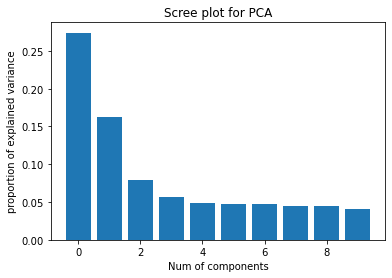

In [37]:
index = np.arange(len(pca.explained_variance_ratio_))
plt.bar(index, pca.explained_variance_ratio_)
plt.title('Scree plot for PCA')
plt.xlabel('Num of components')
plt.ylabel('proportion of explained variance');
